# Question 2

A data follows the following model for a time series:
- Use the notebook get GNP data.ipynb to get the data
- Use AR model on rgnp to predict the last 10 observations. 
    - Adjust the number of lags to consider using any model selection criteria you choose.
- Use VAR model (vector auto-regressive) to predict the last 10 observations of the data
- Replace the prediction models in the last two sections with corresponding LSTM models.
    - The LSTM models should be implemeted in PyTorch. 
    - You should optimize the hidden state size using validation set.
    
Hint: 
- For the regression model you may prefer to work on derivatives of the series. 
- You can check the order of derivation using Augmented Dickey-Fuller test.

In [1]:
import numpy as np
import pandas as pd

In [2]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
test_samples = 10
train_df = df[:-test_samples]
test_df = df[len(train_df):]
# print(df.shape)  # (123, 8)
df.tail()

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0
1989-04-01,4132.5,4044.1,186.1,134.8,129.3,111.1,129.0,100.6
1989-07-01,4162.9,4068.4,187.4,137.2,130.2,109.8,129.9,98.2


1. rgnp  : Real GNP.
2. pgnp  : Potential real GNP.
3. ulc   : Unit labor cost.
4. gdfco : Fixed weight deflator for personal consumption expenditure excluding food and energy.
5. gdf   : Fixed weight GNP deflator.
6. gdfim : Fixed weight import deflator.
7. gdfcf : Fixed weight deflator for food in personal consumption expenditure.
8. gdfce : Fixed weight deflator for energy in personal consumption expenditure.

## Using AR(p) model for rgnp

### Testing for stationarity

In [3]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_df['rgnp'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.081173
p-value: 0.964752


### rndp is not stationary - try fix using first derivative

In [93]:
rgnp_diff = train_df['rgnp'].diff().dropna()
# rgnp_diff = np.log(train_df['rgnp']).diff().dropna()
result = adfuller(rgnp_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.355104
p-value: 0.000004


#### Now it is stationary

### Find the number of required lags/AR terms (order of p)

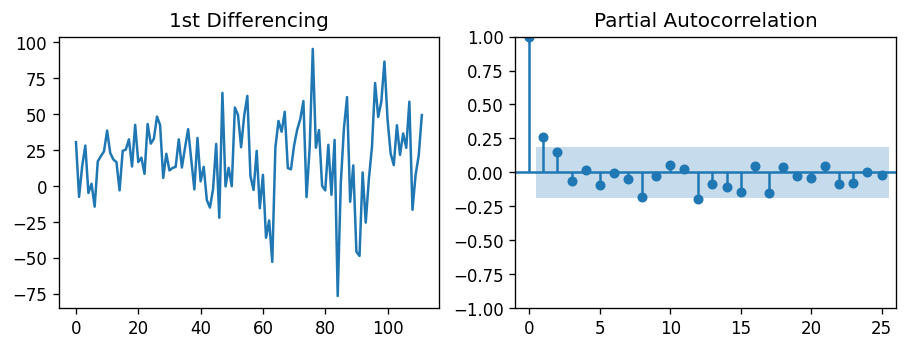

In [94]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(rgnp_diff.values); axes[0].set_title('1st Differencing')
axes[1].set(xlim=(-1 ,26))
plot_pacf(rgnp_diff.values, lags=25, method='ywm', ax = axes[1])

plt.show()

- PACF lag 1 is quite significant since is well above the significance line. 
- Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region)

### Instantiate and fit the AR model with training data

In [95]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(rgnp_diff, lags=2).fit()

# print(ar_model.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


### Plot the prediction vs test data

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


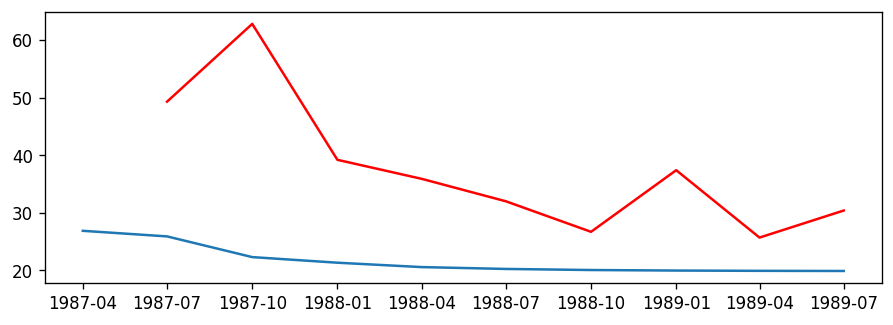

In [97]:
pred = ar_model.predict(start=test_df.index[0], end=test_df.index[-1], dynamic=False)

from matplotlib import pyplot
pyplot.plot(pred)
actual = test_df['rgnp'].diff()
pyplot.plot(actual, color='red')

## Using VAR(p) model for the data